In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from joblib import Parallel
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
import pickle
import time
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
# from sklearn.metrics import r2_score
import warnings
from statsmodels.tsa.stattools import acf

warnings.filterwarnings('ignore')

# !pip install lightgbm
# !pip install dask

In [2]:
file_path = "./data/Clean_Data.csv"  
file_path = "./data/Raw_Data_With_Targets.csv" 

df = pd.read_csv(file_path)
df2 = pd.read_csv("./data/Macro_Data.csv")
df = df.merge(df2, on='LOAN_SEQUENCE_NUMBER', how='left')
df = df[df.ORIGINAL_LOAN_TERM ==360]
df.drop(columns=['Unnamed: 0_x','Unnamed: 0_y'], inplace=True)
df

,FICO,FIRST_PAYMENT_DATE,FIRST_TIME_HOMEBUYER_FLAG,MATURITY_DATE,MI_PERCENTAGE,N_UNITS,OCCUPANCY_STATUS,CLTV,DTI,UPB,...,PREPAID,PREPAYMENT_TIME,HPI_ZIP,HPI_STATE,STATE_PR,STATE_GU,STATE_VI,HPI_ZIP_MISSING_US_MAINLAND,MORTGAGE_RATE,UNEMPLOYMENT_RATE
0,768,200604,N,203603,0,1,P,75,37,130000,...,1.0,39,173.06,177.762206,False,False,False,False,6.243333,4.733333
1,779,200604,N,203603,0,1,P,80,31,214000,...,1.0,36,190.30,177.762206,False,False,False,False,6.243333,4.733333
2,713,200604,N,203603,0,2,P,77,35,81000,...,1.0,75,156.09,153.968437,False,False,False,False,6.243333,4.733333
3,778,200605,N,203604,0,1,P,80,33,296000,...,1.0,52,190.30,177.762206,False,False,False,False,6.243333,4.733333
4,735,200603,N,203602,25,1,P,90,65,255000,...,1.0,87,238.65,244.274112,False,False,False,False,6.243333,4.733333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21120064,606,202310,N,205309,0,1,P,61,31,200000,...,0.0,1,280.11,242.777330,False,False,False,False,6.693333,3.566667
21120065,771,202310,N,205309,0,1,P,95,20,269000,...,0.0,1,299.36,242.777330,False,False,False,False,6.693333,3.566667
21120066,727,202310,N,205309,0,1,P,70,37,504000,...,0.0,1,358.05,328.872521,False,False,False,False,6.693333,3.566667
21120067,763,202310,N,205309,0,1,P,90,23,200000,...,0.0,1,228.72,242.777330,False,False,False,False,6.693333,3.566667


In [3]:
feature_categorical = ['FIRST_TIME_HOMEBUYER_FLAG', 'OCCUPANCY_STATUS', 'CHANNEL', 'PPM_FLAG', 'PROPERTY_STATE', 'PROPERTY_TYPE', 'LOAN_PURPOSE',]
feature_continuous = ['FICO', 'MI_PERCENTAGE', 'N_UNITS', 'CLTV', 'DTI', 'UPB', 'LTV', 'ORIGINAL_INTEREST_RATE', 'POSTAL_CODE', 'N_BORROWERS']
features_macro = ['UNEMPLOYMENT_RATE', 'MORTGAGE_RATE', 'HPI_ZIP', 'HPI_STATE']
feature_missing_indicator = ['MSA_MISSING', 'N_UNITS_MISSING', 'DTI_MISSING', 'N_BORROWERS_MISSING']

In [4]:
def plot_importance(Importance_list, features,PLOT_TOP_N = 30, figsize=(20, 15)):
    importance_df = pd.DataFrame(np.array(Importance_list),columns = features) # row is 4 folds, column is features
    sorted_indices = importance_df.median(axis=0).sort_values(ascending=False).index
    sorted_importance_df = importance_df.loc[:, sorted_indices]
    plot_cols = sorted_importance_df.columns[:PLOT_TOP_N]
    _, ax = plt.subplots(figsize=figsize)
    ax.grid()
    ax.set_xscale('log')
    ax.set_ylabel('Feature')
    ax.set_xlabel('Importance')
    sns.boxplot(data=sorted_importance_df[plot_cols],
                orient='h',
                ax=ax)
    plt.show()

def get_time_series_cross_val_splits(feature_df,year = 2016, how_long = [1,2,4], n_fold = 5):
    # actually just use K-fold in this case
    kf = KFold(n_splits=n_fold)
    feature_df['ORIGINATION_YEAR'] = feature_df['FIRST_PAYMENT_DATE'].apply(lambda x: int(str(x)[:4]))
    feature_df = feature_df[feature_df.ORIGINATION_YEAR == year]
    feature_df["PREPAID"] = feature_df["PREPAID"].apply(lambda x: True if x else False)

    for _ in how_long:
        feature_df[f"target_{_}"] = ((feature_df["PREPAID"]) & (feature_df["PREPAYMENT_TIME"] <= _*12))
    for train_index, test_index in kf.split(feature_df):
        # print(len(train_index)/len(feature_df), len(test_index)/len(feature_df))
        train, test = feature_df.iloc[train_index], feature_df.iloc[test_index]
        yield train, test

In [9]:
# # some traits of the loan
# LOAN_SEQUENCE_NUMBER, ORIGINAL_LOAN_TERM, FIRST_PAYMENT_DATE,MATURITY_DATE
# # Target
# PREPAID,PREPAYMENT_TIME
# pd.set_option('display.max_columns', None)
# display(df.head())
# print(len(df))
# df.head()

**********Entering time series cross validation loop**********


  0%|          | 0/1 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 285122, number of negative: 566305
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016004 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1771
[LightGBM] [Info] Number of data points in the train set: 851427, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.334875 -> initscore=-0.686216
[LightGBM] [Info] Start training from score -0.686216
Training until validation scores don't improve for 100 rounds


100%|██████████| 1/1 [00:02<00:00,  2.79s/it]

Early stopping, best iteration is:
[10]	train's binary_logloss: 0.635273	val's binary_logloss: 0.644732


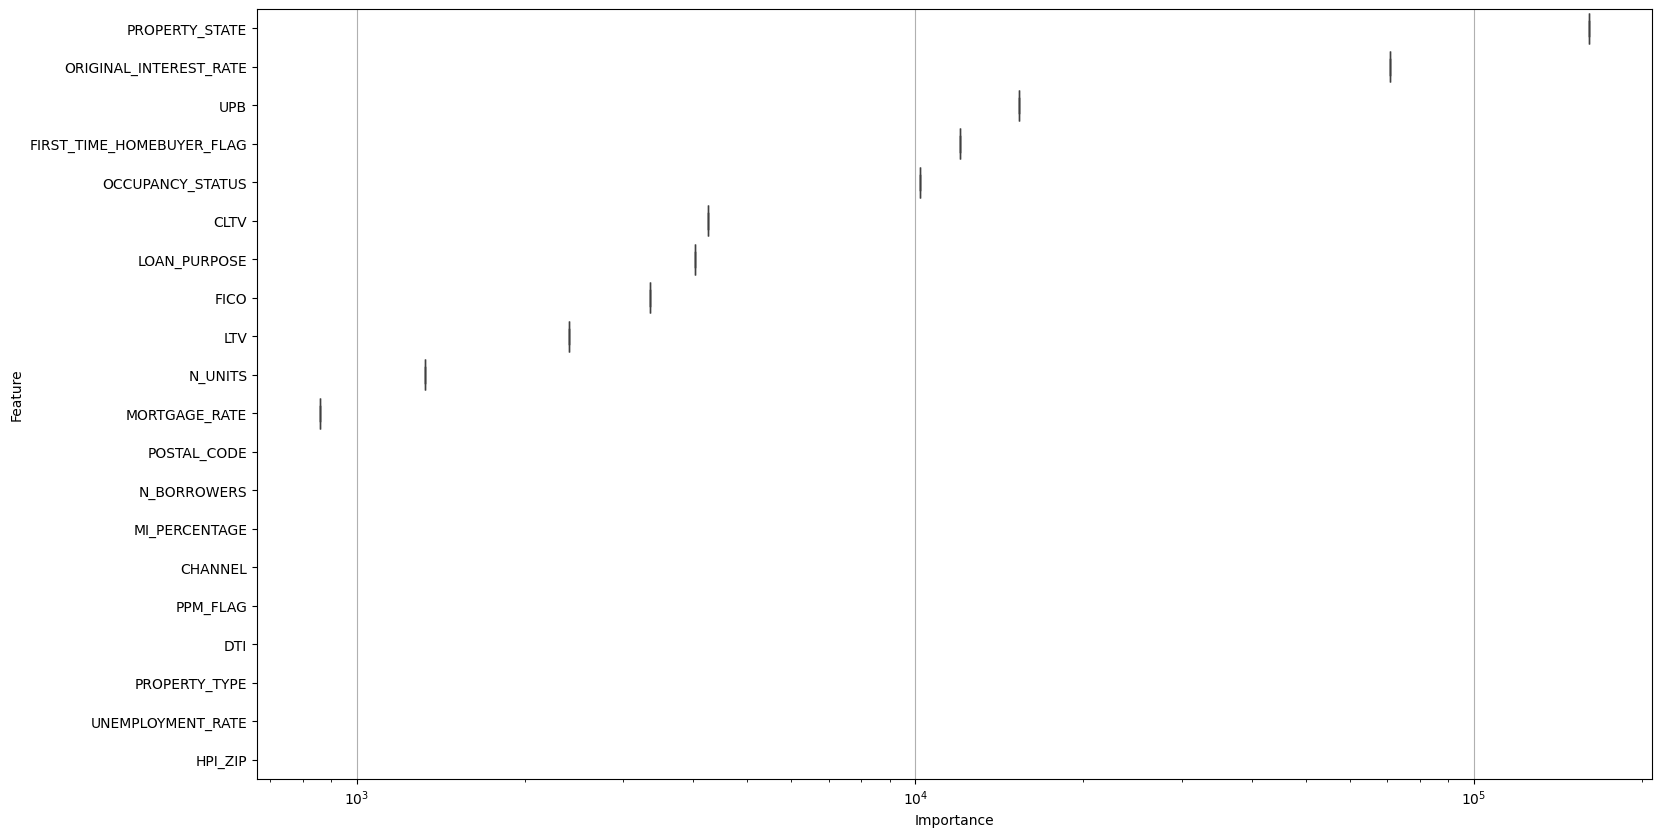

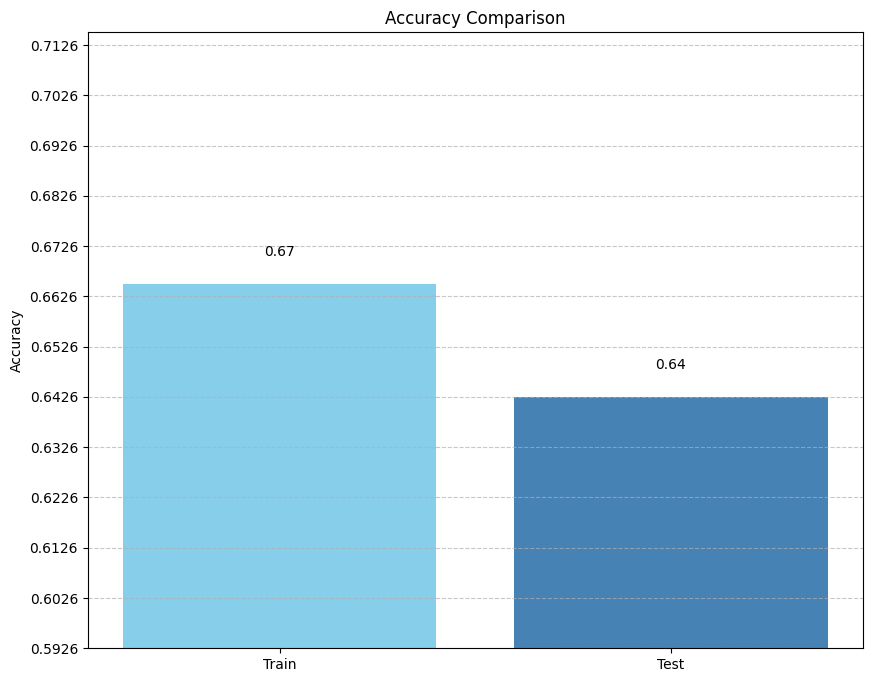

In [45]:
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

def get_Xy_and_model_for_asset(params, feature_df, features=None):
    if features is None:
        features = feature_continuous+feature_categorical+features_macro  # default to use all features

    categorical_features = feature_categorical  # Your categorical variable column name
    
    label_encoders = {}
    for feature in categorical_features:
        le = LabelEncoder()
        feature_df[feature] = le.fit_transform(feature_df[feature])
        label_encoders[feature] = le
    
    feature_df = feature_df.sort_values(by='FIRST_PAYMENT_DATE')
    feature_df['ORIGINATION_YEAR'] = feature_df['FIRST_PAYMENT_DATE'].apply(lambda x: int(str(x)[:4]))
    feature_df["PREPAID"] = feature_df["PREPAID"].apply(lambda x: True if x else False)
    
    for _ in [0.5,1,2,4]:
        feature_df[f"target_{_}"] = ((feature_df["PREPAID"]) & (feature_df["PREPAYMENT_TIME"] <= _*12))
    
    print('*' * 10 + "Entering time series cross validation loop" + '*' * 10)
    statistics = {
        "Importance_list": [],
        "Tree_num_list": [],
        "y_pred_list": [],
        "y_true_list": [],
        "ROC_AUC_list": [],
        "Precision_list": [],
        "Recall_list": [],
        "F1_score_list": [],
    }

    for year in tqdm(range(2016, 2017)):
        year_data = feature_df[feature_df.ORIGINATION_YEAR == year]

        train_size = int(0.8 * len(year_data))
        train_splits = year_data[:train_size]
        test_splits = year_data[train_size:]

        y_train = train_splits['target_4']
        y_test = test_splits['target_4']
        X_train = train_splits[features]
        X_test = test_splits[features]
        train_dataset = lgb.Dataset(X_train, label=y_train)
        val_dataset = lgb.Dataset(X_test, label=y_test)

        model = lgb.train(params=params,
                          train_set=train_dataset,
                          valid_sets=[train_dataset, val_dataset],
                          valid_names=['train', 'val'],
                          categorical_feature=categorical_features  # Specify categorical features
                          )
        importance = model.feature_importance(importance_type='gain')
        statistics["Importance_list"].append(importance)
        statistics["Tree_num_list"].append(model.best_iteration)

        y_pred = model.predict(X_test)

        statistics["y_pred_list"].append(y_pred)
        statistics["y_true_list"].append(y_test)

    plot_importance(np.array(statistics["Importance_list"]), features, PLOT_TOP_N=20, figsize=(18, 10))

    return X_train, y_train, X_test, y_test, model, statistics

params = {'objective': 'binary',
          'metric': 'binary_logloss',
          'boosting_type': 'gbdt',
          'is_unbalance': True,
          'n_estimators':2000,
          'num_leaves':15,
          'learning_rate':0.05,
          'seed':42,
          'verbose': 1,
          'early_stopping_rounds': 100,
          'metric_freq':10,
          }
X_train, y_train, X_test, y_test, model, statistics_lgbm = get_Xy_and_model_for_asset(params,df,features =None)

# Calculate accuracy
# Calculate accuracy
y_train_pred = (model.predict(X_train) > 0.5).astype(int)
y_test_pred = (model.predict(X_test) > 0.5).astype(int)
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

# Plot accuracy
plt.figure(figsize=(10, 8))
bars = plt.bar(['Train', 'Test'], [train_accuracy, test_accuracy], color=['skyblue', 'steelblue'])

# Add some text for labels, title and custom x-axis tick labels, etc.
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.ylim([min(train_accuracy, test_accuracy) - 0.05, max(train_accuracy, test_accuracy) + 0.05])

# Increase y-ticks density
plt.yticks(np.arange(min(train_accuracy, test_accuracy) - 0.05, max(train_accuracy, test_accuracy) + 0.05, 0.01))

# Labeling the bars with their respective values
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.005, round(yval, 2), ha='center', va='bottom')

plt.show()

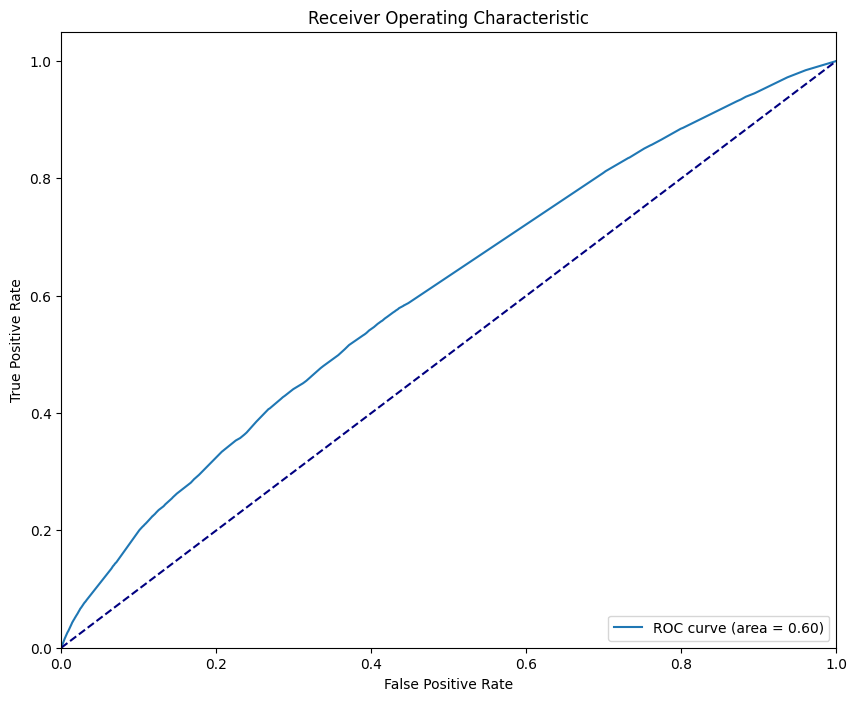

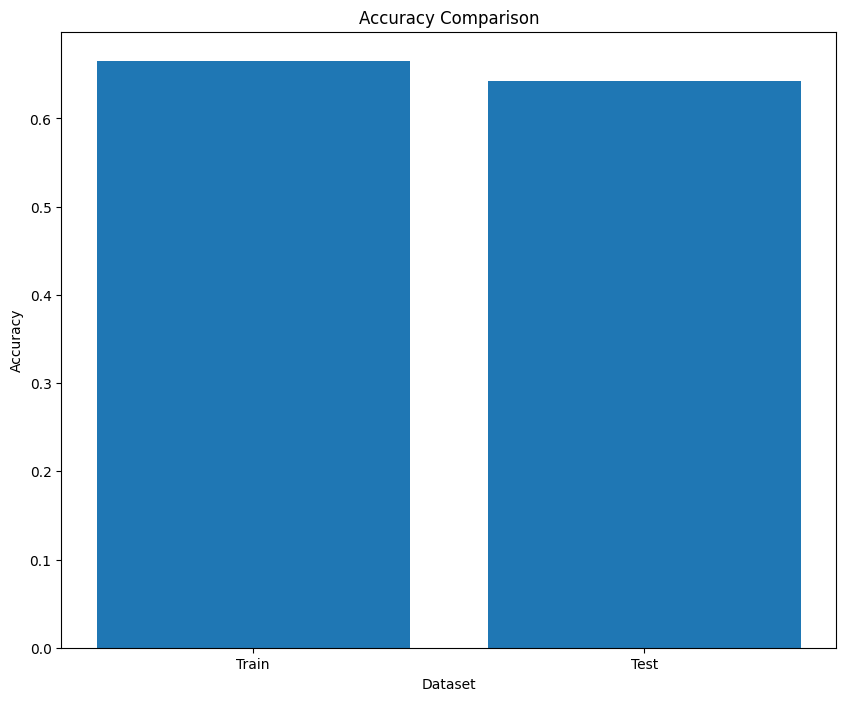

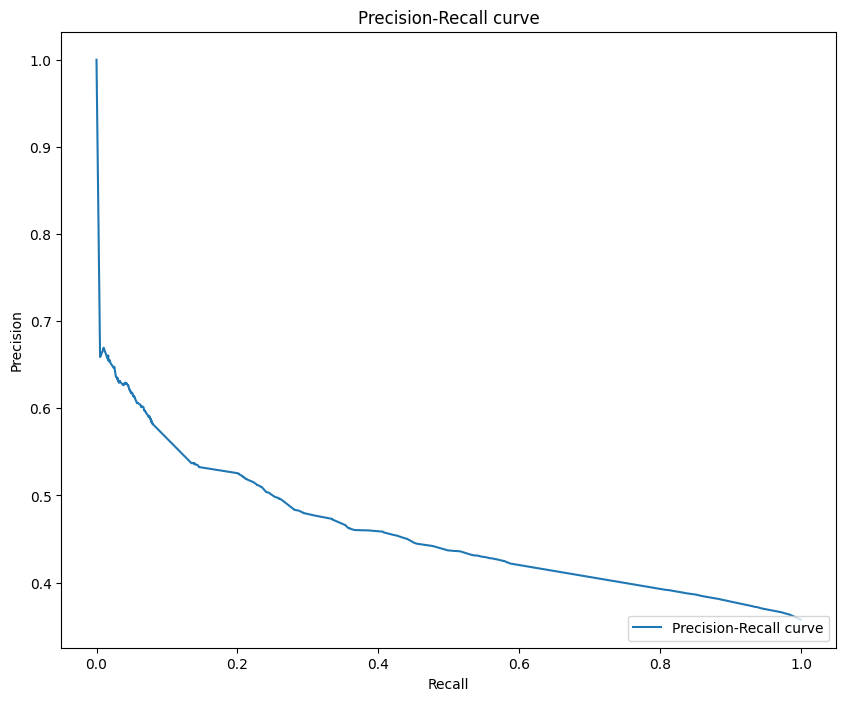

In [41]:
from sklearn.metrics import accuracy_score

statistics = statistics_lgbm
# ROC Curve
plt.figure(figsize=(10, 8))
for i in range(len(statistics["y_true_list"])):
    fpr, tpr, _ = roc_curve(statistics["y_true_list"][i], statistics["y_pred_list"][i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Accuracy comparison
plt.figure(figsize=(10, 8))
plt.bar(['Train', 'Test'], [train_accuracy, test_accuracy])
plt.xlabel('Dataset')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison')
plt.show()

# Precision-Recall curve
plt.figure(figsize=(10, 8))
for i in range(len(statistics["y_true_list"])):
    precision, recall, _ = precision_recall_curve(statistics["y_true_list"][i], statistics["y_pred_list"][i])
    plt.plot(recall, precision, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc="lower right")
plt.show()

Epoch 1/20
26608/26608 ━━━━━━━━━━━━━━━━━━━━ 19s 709us/step - accuracy: 0.6729 - loss: 0.6193 - val_accuracy: 0.6490 - val_loss: 0.6589
Epoch 2/20
26608/26608 ━━━━━━━━━━━━━━━━━━━━ 18s 693us/step - accuracy: 0.6751 - loss: 0.6150 - val_accuracy: 0.6494 - val_loss: 0.6527
Epoch 3/20
26608/26608 ━━━━━━━━━━━━━━━━━━━━ 19s 705us/step - accuracy: 0.6763 - loss: 0.6130 - val_accuracy: 0.6505 - val_loss: 0.6508
Epoch 4/20
26608/26608 ━━━━━━━━━━━━━━━━━━━━ 19s 699us/step - accuracy: 0.6768 - loss: 0.6121 - val_accuracy: 0.6493 - val_loss: 0.6587
Epoch 5/20
26608/26608 ━━━━━━━━━━━━━━━━━━━━ 19s 715us/step - accuracy: 0.6778 - loss: 0.6108 - val_accuracy: 0.6505 - val_loss: 0.6463
Epoch 6/20
26608/26608 ━━━━━━━━━━━━━━━━━━━━ 19s 714us/step - accuracy: 0.6775 - loss: 0.6107 - val_accuracy: 0.6505 - val_loss: 0.6493
Epoch 7/20
26608/26608 ━━━━━━━━━━━━━━━━━━━━ 19s 721us/step - accuracy: 0.6780 - loss: 0.6102 - val_accuracy: 0.6505 - val_loss: 0.6533
Epoch 8/20
26608/26608 ━━━━━━━━━━━━━━━━━━━━ 19s 715us/s

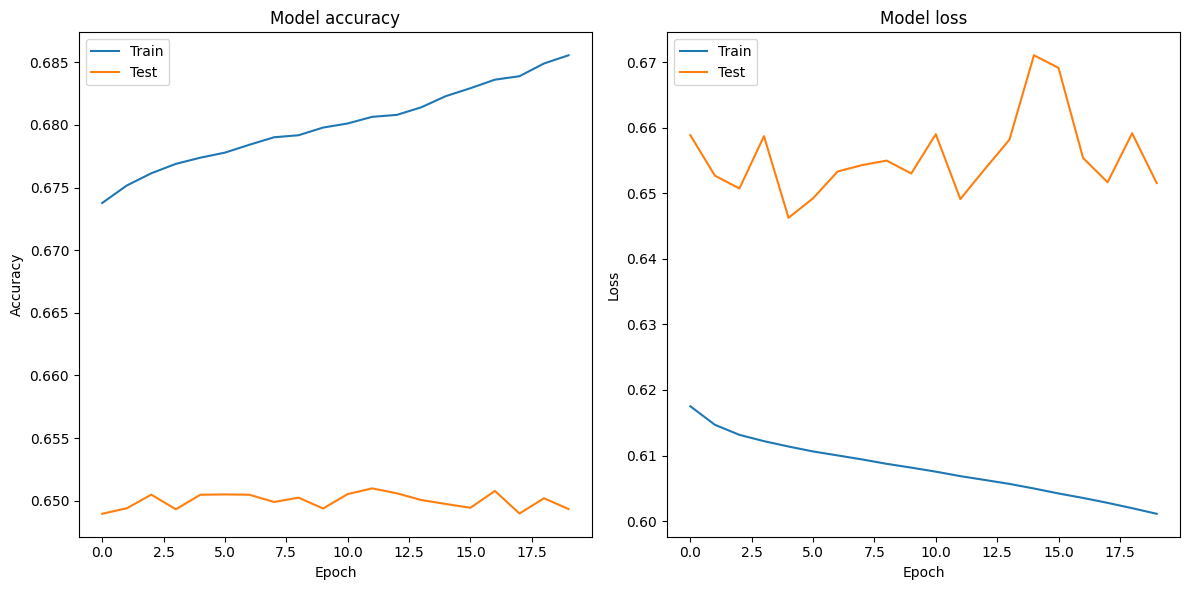

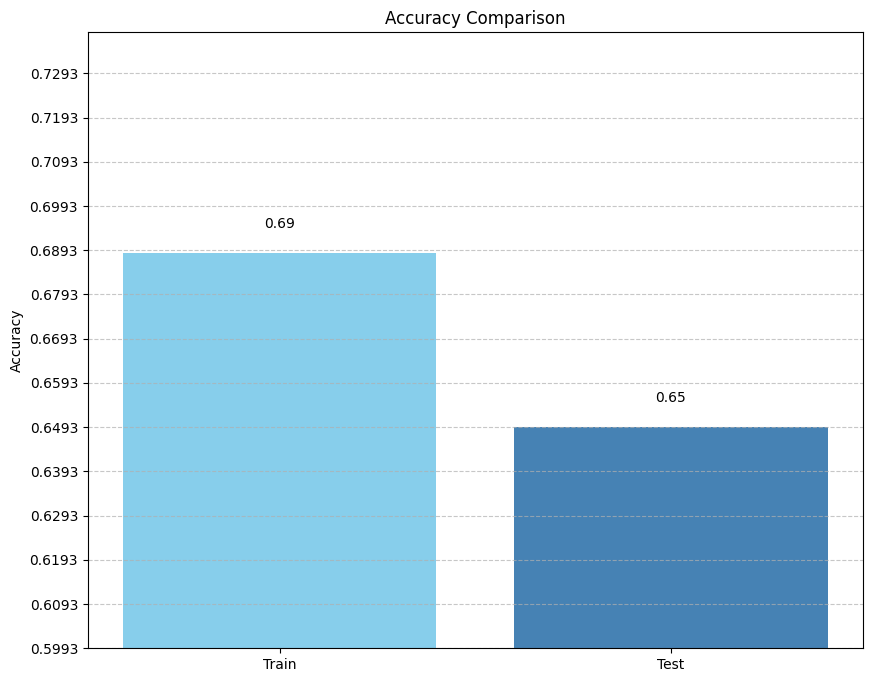

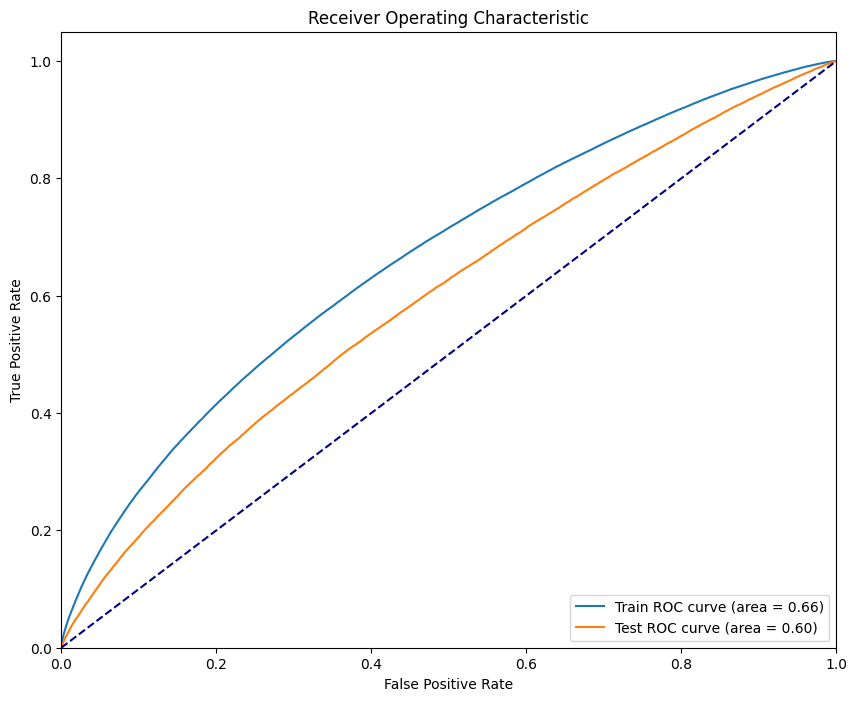

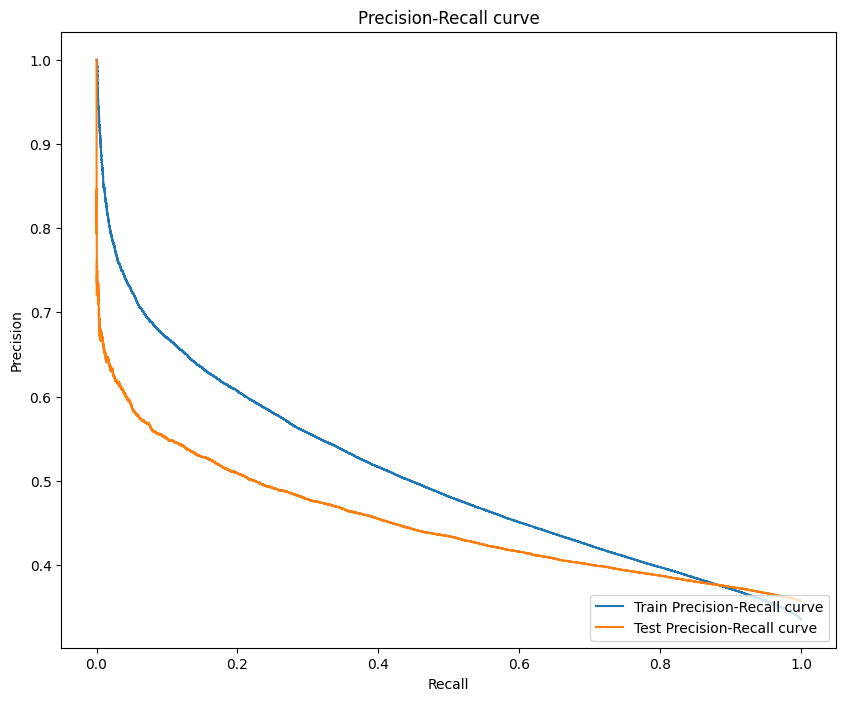

In [49]:
# !pip install tensorflow
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

year = 2016

def get_Xy_and_model_for_asset_nn(feature_df, features=None, learning_rate=0.001):
    """
    Doing CV on the first 4 folds
    :param feature_df:
    :param features:
    :return:
    """
    if features is None:
        features = feature_continuous+feature_categorical+features_macro  # default to use all features

    # Perform label encoding on categorical variables.
    categorical_features = feature_categorical  # Your categorical variable column name
    
    label_encoders = {}
    for feature in categorical_features:
        le = LabelEncoder()
        feature_df[feature] = le.fit_transform(feature_df[feature])
        label_encoders[feature] = le
    
    # Split the data into training and test sets#############
    feature_df['ORIGINATION_YEAR'] = feature_df['FIRST_PAYMENT_DATE'].apply(lambda x: int(str(x)[:4]))
    feature_df = feature_df[feature_df.ORIGINATION_YEAR == year]
    feature_df["PREPAID"] = feature_df["PREPAID"].apply(lambda x: True if x else False)

    for _ in [0.5,1,2,4]:
        feature_df[f"target_{_}"] = ((feature_df["PREPAID"]) & (feature_df["PREPAYMENT_TIME"] <= _*12))
        
    ##########################################################
    # Sort the dataframe by FIRST_PAYMENT_DATE
    feature_df = feature_df.sort_values(by='FIRST_PAYMENT_DATE')

    # Split the data into training and test sets based on the index
    train_size = int(0.8 * len(feature_df))
    train_splits = feature_df[:train_size]
    test_splits = feature_df[train_size:]

    y_train = train_splits['target_4']
    y_test = test_splits['target_4']
    train_splits = train_splits[features]
    test_splits = test_splits[features]

    # Standardize the features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(train_splits)
    X_test = scaler.transform(test_splits)

    # Define the model
    model = Sequential()
    model.add(Dense(200, input_dim=X_train.shape[1], activation='relu'))
    model.add(Dense(140, activation='relu'))
    model.add(Dense(140, activation='relu'))
    model.add(Dense(140, activation='relu'))
    model.add(Dense(140, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    # Compile the model
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=learning_rate), metrics=['accuracy'])

    # Train the model
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=32, verbose=1)

    # Predict on the test set
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    # Calculate accuracy
    y_train_pred = (y_pred_train > 0.5).astype(int)
    y_test_pred = (y_pred_test > 0.5).astype(int)
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)

    statistics = {
        "y_pred_train": y_pred_train,
        "y_pred_test": y_pred_test,
        "y_true_train": y_train,
        "y_true_test": y_test,
        "train_accuracy": train_accuracy,
        "test_accuracy": test_accuracy,
        "history": history,
    }
    
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')

    plt.tight_layout()
    plt.show()

    return statistics

statistics_nn = get_Xy_and_model_for_asset_nn(df,features =None, learning_rate=0.0002)
statistics = statistics_nn
# Accuracy comparison
plt.figure(figsize=(10, 8))
bars = plt.bar(['Train', 'Test'], [statistics["train_accuracy"], statistics["test_accuracy"]], color=['skyblue', 'steelblue'])
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.ylim([min(statistics["train_accuracy"], statistics["test_accuracy"]) - 0.05, max(statistics["train_accuracy"], statistics["test_accuracy"]) + 0.05])
plt.yticks(np.arange(min(statistics["train_accuracy"], statistics["test_accuracy"]) - 0.05, max(statistics["train_accuracy"], statistics["test_accuracy"]) + 0.05, 0.01))
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.005, round(yval, 2), ha='center', va='bottom')
plt.show()

# ROC Curve
plt.figure(figsize=(10, 8))
for y_true, y_pred, label in zip([statistics["y_true_train"], statistics["y_true_test"]], [statistics["y_pred_train"], statistics["y_pred_test"]], ['Train', 'Test']):
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='%s ROC curve (area = %0.2f)' % (label, roc_auc))
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Precision-Recall curve
plt.figure(figsize=(10, 8))
for y_true, y_pred, label in zip([statistics["y_true_train"], statistics["y_true_test"]], [statistics["y_pred_train"], statistics["y_pred_test"]], ['Train', 'Test']):
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    plt.plot(recall, precision, label='%s Precision-Recall curve' % label)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc="lower right")
plt.show()

KeyError: 'y_true_list'

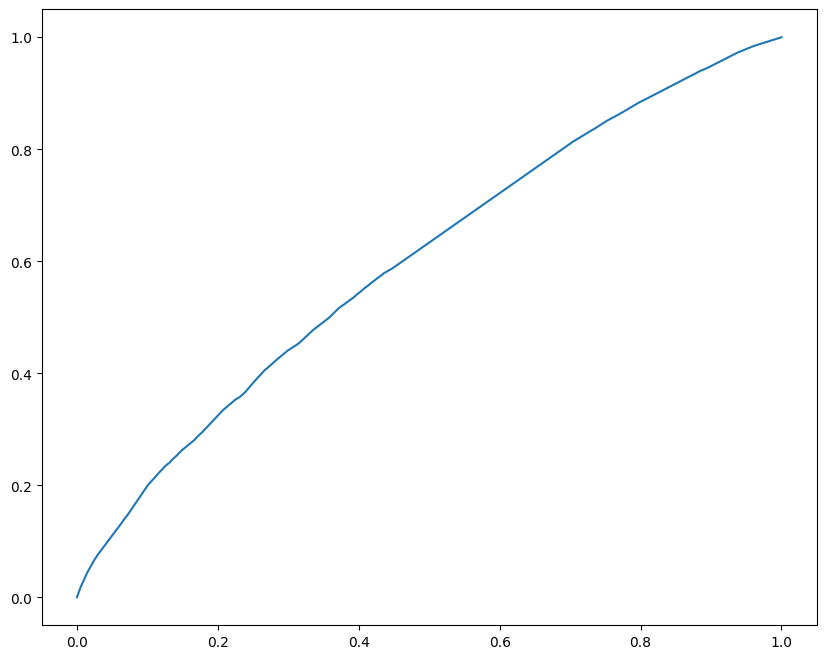

In [48]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt

# ROC Curve
plt.figure(figsize=(10, 8))
for statistics, label in zip([statistics_lgbm, statistics_nn], ['LightGBM', 'Neural Network']):
    for i in range(len(statistics["y_true_list"])):
        fpr, tpr, _ = roc_curve(statistics["y_true_list"][i], statistics["y_pred_list"][i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label='%s ROC curve (area = %0.2f)' % (label, roc_auc))
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Accuracy comparison
plt.figure(figsize=(10, 8))
bars = plt.bar(['Train (LightGBM)', 'Test (LightGBM)', 'Train (Neural Network)', 'Test (Neural Network)'], 
               [statistics_lgbm["train_accuracy"], statistics_lgbm["test_accuracy"], statistics_nn["train_accuracy"], statistics_nn["test_accuracy"]], 
               color=['skyblue', 'steelblue', 'lightgreen', 'darkgreen'])
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.ylim([min(statistics_lgbm["train_accuracy"], statistics_lgbm["test_accuracy"], statistics_nn["train_accuracy"], statistics_nn["test_accuracy"]) - 0.05, 
           max(statistics_lgbm["train_accuracy"], statistics_lgbm["test_accuracy"], statistics_nn["train_accuracy"], statistics_nn["test_accuracy"]) + 0.05])
plt.yticks(np.arange(min(statistics_lgbm["train_accuracy"], statistics_lgbm["test_accuracy"], statistics_nn["train_accuracy"], statistics_nn["test_accuracy"]) - 0.05, 
                     max(statistics_lgbm["train_accuracy"], statistics_lgbm["test_accuracy"], statistics_nn["train_accuracy"], statistics_nn["test_accuracy"]) + 0.05, 0.01))
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.005, round(yval, 2), ha='center', va='bottom')
plt.show()

# Precision-Recall curve
plt.figure(figsize=(10, 8))
for statistics, label in zip([statistics_lgbm, statistics_nn], ['LightGBM', 'Neural Network']):
    for i in range(len(statistics["y_true_list"])):
        precision, recall, _ = precision_recall_curve(statistics["y_true_list"][i], statistics["y_pred_list"][i])
        plt.plot(recall, precision, label='%s Precision-Recall curve' % label)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc="lower right")
plt.show()